# Homework 9

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence expect for 2, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

In [1]:
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

In [2]:
addition_problem(10)

(array([[ 0.        , -0.65826593],
        [ 0.        ,  0.60228335],
        [ 0.        , -0.04416288],
        [ 1.        , -0.01130421],
        [ 0.        , -0.81115185],
        [ 0.        ,  0.2488151 ],
        [ 1.        , -0.37346769],
        [ 0.        ,  0.31698922],
        [ 0.        ,  0.64959472],
        [ 0.        ,  0.62665656]]), array([-0.38477191]))

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# Attention Pooling Layer
class AttentionPooling(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super(AttentionPooling, self).__init__()
        self.W_a = nn.Linear(input_dim, attention_dim)
        self.q = nn.Parameter(torch.randn(attention_dim))

    def forward(self, x):
        energy = torch.matmul(torch.tanh(self.W_a(x)), self.q)
        attention_weights = torch.softmax(energy, dim=1)
        context = torch.sum(attention_weights.unsqueeze(2) * x, dim=1)
        return context

In [5]:
# Addition Problem Model
class AdditionProblemModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, attention_dim, output_dim):
        super(AdditionProblemModel, self).__init__()
        self.ff1 = nn.Linear(input_dim, hidden_dim)
        self.attention_pooling = AttentionPooling(hidden_dim, attention_dim)
        self.ff2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.ff1(x))
        x = self.attention_pooling(x)
        x = torch.relu(self.ff2(x))
        x = self.output(x)
        return x

In [6]:
# Train
def train(model, criterion, optimizer, epochs, batch_size, sequence_length):

    loss_list = []

    for epoch in range(epochs):
        # Prepare data
        X, y = [], []
        for _ in range(batch_size):
            sequence, target = addition_problem(sequence_length)
            X.append(sequence)
            y.append(target)

        X = np.array(X)
        y = np.array(y)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(X)
        
        # Compute loss
        loss = criterion(output, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # store loss
        loss_list.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')
    
    return loss_list

In [7]:
%%time

# Hyperparameters
input_dim = 2
hidden_dim = 128
attention_dim = 64
output_dim = 1
lr = 0.001

epochs = 5000
batch_size = 32
sequence_length = 50

# Create the model, loss function, and optimizer
model = AdditionProblemModel(input_dim, hidden_dim, attention_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
loss_list = train(model, criterion, optimizer, epochs, batch_size, sequence_length)

Epoch [100/5000], Loss: 0.12249094
Epoch [200/5000], Loss: 0.06460960
Epoch [300/5000], Loss: 0.03581068
Epoch [400/5000], Loss: 0.00261788
Epoch [500/5000], Loss: 0.00082357
Epoch [600/5000], Loss: 0.00023833
Epoch [700/5000], Loss: 0.00012625
Epoch [800/5000], Loss: 0.00010693
Epoch [900/5000], Loss: 0.00018698
Epoch [1000/5000], Loss: 0.00004012
Epoch [1100/5000], Loss: 0.00004479
Epoch [1200/5000], Loss: 0.00012964
Epoch [1300/5000], Loss: 0.00006099
Epoch [1400/5000], Loss: 0.00008340
Epoch [1500/5000], Loss: 0.00010475
Epoch [1600/5000], Loss: 0.00017092
Epoch [1700/5000], Loss: 0.00164493
Epoch [1800/5000], Loss: 0.00008815
Epoch [1900/5000], Loss: 0.00109084
Epoch [2000/5000], Loss: 0.00604970
Epoch [2100/5000], Loss: 0.00004935
Epoch [2200/5000], Loss: 0.00002979
Epoch [2300/5000], Loss: 0.00001112
Epoch [2400/5000], Loss: 0.00008334
Epoch [2500/5000], Loss: 0.00057831
Epoch [2600/5000], Loss: 0.00295377
Epoch [2700/5000], Loss: 0.00033617
Epoch [2800/5000], Loss: 0.00002578
E

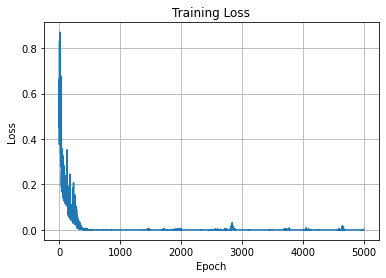

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [9]:
# Test
def test(sequence_length, model):
    sequence, target = addition_problem(sequence_length)

    # print(sequence)
    # print(target)

    X_test = torch.tensor(sequence[np.newaxis, :], dtype=torch.float32)
    y_test = torch.tensor(target[np.newaxis, :], dtype=torch.float32)

    with torch.no_grad():
        output = model(X_test)
        print('Target Sum:', y_test.item())
        print('Model Output:', output.item())


test(sequence_length, model)

Target Sum: -0.32009121775627136
Model Output: -0.3398952782154083


Sequence Length: 50, Average Squared Error: 0.00028617
Sequence Length: 55, Average Squared Error: 0.00051671
Sequence Length: 65, Average Squared Error: 0.00108775
Sequence Length: 80, Average Squared Error: 0.00244350
Sequence Length: 100, Average Squared Error: 0.00505041
Sequence Length: 125, Average Squared Error: 0.00909538
Sequence Length: 150, Average Squared Error: 0.01480902


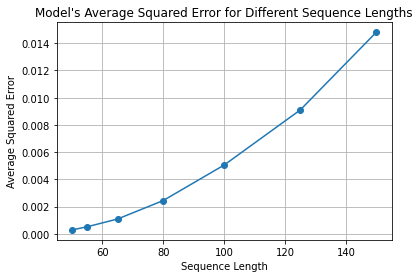

In [10]:
# Test the model on different sequence lengths
sequence_lengths = [50, 55, 65, 80, 100, 125, 150]
num_sequences = 1000
avg_squared_errors = []

for length in sequence_lengths:
    squared_errors = []
    for _ in range(num_sequences):
        sequence, target = addition_problem(length)
        X_test = torch.tensor(sequence[np.newaxis, :], dtype=torch.float32)
        y_test = torch.tensor(target[np.newaxis, :], dtype=torch.float32)

        with torch.no_grad():
            output = model(X_test)
            squared_error = (output - y_test).pow(2).item()
            squared_errors.append(squared_error)
    
    avg_squared_error = np.mean(squared_errors)
    avg_squared_errors.append(avg_squared_error)

    print(f"Sequence Length: {length}, Average Squared Error: {avg_squared_error:.8f}")

# Plot the results
plt.plot(sequence_lengths, avg_squared_errors, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Average Squared Error')
plt.title('Model\'s Average Squared Error for Different Sequence Lengths')
plt.grid()
plt.show()

As we can see, the model's error get worse for longer sequences.